In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
import os
from peft import LoraConfig, get_peft_model
from transformers import CLIPModel, CLIPProcessor, get_cosine_schedule_with_warmup
from torch.amp import GradScaler, autocast 
from tqdm import tqdm

# --- 1. DIRECT PATH CONFIGURATION ---
# SET YOUR PATHS HERE ONCE
IMG_ROOT = r"F:\research\chatbot\D\Multi-modal-codes" 
TRAIN_TSV = os.path.join(IMG_ROOT, "data/CrisisMMD/crisismmd_datasplit_all/crisismmd_datasplit_all/task_damage_text_img_train.tsv")
TEST_TSV  = os.path.join(IMG_ROOT, "data/CrisisMMD/crisismmd_datasplit_all/crisismmd_datasplit_all/task_damage_text_img_test.tsv")

# --- 2. DATASET LOADER ---
class CrisisDamageDataset(Dataset):
    def __init__(self, filepath, img_dir, processor):
        self.data = pd.read_csv(filepath, sep='\t')
        self.img_dir = img_dir
        self.processor = processor
        self.label_map = {"severe_damage": 0, "mild_damage": 1, "little_or_no_damage": 2}

    def __len__(self): return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = os.path.normpath(os.path.join(self.img_dir, str(row['image']).replace('\\', '/').lstrip('/')))
        
        if not os.path.exists(img_path): return None

        try:
            image = Image.open(img_path).convert("RGB")
            inputs = self.processor(text=[str(row['tweet_text'])], images=image, 
                                    return_tensors="pt", padding="max_length", 
                                    max_length=77, truncation=True)
            return {
                'input_ids': inputs['input_ids'].squeeze(0),
                'attention_mask': inputs['attention_mask'].squeeze(0),
                'pixel_values': inputs['pixel_values'].squeeze(0),
                'label': torch.tensor(self.label_map[row['label']], dtype=torch.long)
            }
        except Exception: return None

def fast_collate(batch):
    batch = list(filter(lambda x: x is not None, batch))
    return torch.utils.data.dataloader.default_collate(batch) if len(batch) > 0 else None

# --- 3. ARCHITECTURE: SYMMETRIC DUAL-PATH FUSION ---
class SymmetricFusion(nn.Module):
    """Mutual verification: Text queries Image and Image queries Text."""
    def __init__(self, embed_dim=512):
        super().__init__()
        self.gate = nn.Sequential(nn.Linear(embed_dim * 2, 512), nn.GELU(), nn.Linear(512, embed_dim * 2), nn.Sigmoid())
        self.norm = nn.LayerNorm(embed_dim * 2)
        self.gamma = nn.Parameter(1e-4 * torch.ones(embed_dim * 2))

    def forward(self, t_f, i_f):
        # Flash-based Scaled Dot Product Attention
        a_t = F.scaled_dot_product_attention(t_f.unsqueeze(1), i_f.unsqueeze(1), i_f.unsqueeze(1)).squeeze(1)
        a_i = F.scaled_dot_product_attention(i_f.unsqueeze(1), t_f.unsqueeze(1), t_f.unsqueeze(1)).squeeze(1)
        combined = torch.cat((a_t, a_i), dim=1)
        return self.norm(self.gamma * (combined * self.gate(combined)) + torch.cat((t_f, i_f), dim=1))

class DamageSeverityClassifier(nn.Module):
    def __init__(self, model_id="openai/clip-vit-base-patch32", num_classes=3):
        super().__init__()
        self.clip = CLIPModel.from_pretrained(model_id, use_safetensors=True)
        self.fusion = SymmetricFusion()
        self.classifier = nn.Sequential(
            nn.Linear(1024, 512), nn.BatchNorm1d(512), nn.GELU(),
            nn.Dropout(0.5), nn.Linear(512, 128), nn.GELU(), nn.Linear(128, num_classes)
        )

    def forward(self, ids, mask, pix):
        t_f = self.clip.get_text_features(input_ids=ids, attention_mask=mask)
        i_f = self.clip.get_image_features(pixel_values=pix)
        t_f, i_f = F.normalize(t_f, p=2, dim=-1), F.normalize(i_f, p=2, dim=-1)
        return self.classifier(self.fusion(t_f, i_f))

# --- 4. EXECUTION SETTINGS ---
device = torch.device("cuda")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32", use_fast=True)

train_loader = DataLoader(CrisisDamageDataset(TRAIN_TSV, IMG_ROOT, processor), batch_size=16, shuffle=True, collate_fn=fast_collate)
test_loader  = DataLoader(CrisisDamageDataset(TEST_TSV, IMG_ROOT, processor), batch_size=16, shuffle=False, collate_fn=fast_collate)

model = DamageSeverityClassifier().to(device)
# LoRA Rank 128 captures the fine-grained visual details of structural damage
model = get_peft_model(model, LoraConfig(r=128, lora_alpha=256, target_modules=["q_proj", "v_proj"]))

# Differential Learning Rates: Fast for fusion, slow for backbone
optimizer = optim.AdamW([
    {'params': [p for n, p in model.named_parameters() if 'clip' in n], 'lr': 1e-5, 'weight_decay': 0.1},
    {'params': [p for n, p in model.named_parameters() if 'clip' not in n], 'lr': 1.5e-4, 'weight_decay': 0.05}
])

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=150, num_training_steps=len(train_loader)*15)
criterion = nn.CrossEntropyLoss(label_smoothing=0.25) # Resolves the "Severe vs Mild" overlap
scaler = GradScaler('cuda')

# --- 5. TRAINING LOOP ---
print(f"🚀 Launching Ultimate Damage Severity Run. Target: > 0.9000")
best_acc = 0

for epoch in range(15):
    model.train()
    total_loss, count = 0, 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        if batch is None: continue
        ids, mask, pix, lbl = [batch[k].to(device) for k in ['input_ids', 'attention_mask', 'pixel_values', 'label']]
        
        optimizer.zero_grad(set_to_none=True)
        with autocast('cuda'):
            loss = criterion(model(ids, mask, pix), lbl)
        
        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()
        total_loss += loss.item()
        count += 1
    
    print(f"📉 Epoch {epoch+1} Avg Loss: {total_loss/max(1, count):.4f}")

# Final Evaluation
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for b in tqdm(test_loader, desc="Testing"):
        if b is None: continue
        out = model(b['input_ids'].to(device), b['attention_mask'].to(device), b['pixel_values'].to(device))
        correct += (torch.argmax(out, 1) == b['label'].to(device)).sum().item()
        total += b['label'].size(0)

print(f"\n🏆 FINAL TEST ACCURACY: {correct/total:.4f}")

Epoch 1: 100%|██████████| 155/155 [00:57<00:00,  2.71it/s, loss=1.1, step_acc=0.6086]  



📈 Epoch 1 Summary: Train Acc: 0.6086 | Test Acc: 0.5728
✅ Validation accuracy increased. Saving model...


Epoch 2: 100%|██████████| 155/155 [00:59<00:00,  2.63it/s, loss=0.924, step_acc=0.6074]



📈 Epoch 2 Summary: Train Acc: 0.6074 | Test Acc: 0.5520
⚠️ EarlyStopping counter: 1 out of 3


Epoch 3: 100%|██████████| 155/155 [00:57<00:00,  2.72it/s, loss=1.05, step_acc=0.6130] 



📈 Epoch 3 Summary: Train Acc: 0.6130 | Test Acc: 0.6049
✅ Validation accuracy increased. Saving model...


Epoch 4: 100%|██████████| 155/155 [01:39<00:00,  1.55it/s, loss=1.05, step_acc=0.6394] 



📈 Epoch 4 Summary: Train Acc: 0.6394 | Test Acc: 0.5936
⚠️ EarlyStopping counter: 1 out of 3


Epoch 5: 100%|██████████| 155/155 [00:56<00:00,  2.74it/s, loss=1.07, step_acc=0.6406] 



📈 Epoch 5 Summary: Train Acc: 0.6406 | Test Acc: 0.6163
✅ Validation accuracy increased. Saving model...


Epoch 6: 100%|██████████| 155/155 [00:57<00:00,  2.70it/s, loss=0.953, step_acc=0.6613]



📈 Epoch 6 Summary: Train Acc: 0.6613 | Test Acc: 0.6408
✅ Validation accuracy increased. Saving model...


Epoch 7: 100%|██████████| 155/155 [00:57<00:00,  2.69it/s, loss=1.07, step_acc=0.6856] 



📈 Epoch 7 Summary: Train Acc: 0.6856 | Test Acc: 0.6635
✅ Validation accuracy increased. Saving model...


Epoch 8: 100%|██████████| 155/155 [00:59<00:00,  2.61it/s, loss=0.883, step_acc=0.7229]



📈 Epoch 8 Summary: Train Acc: 0.7229 | Test Acc: 0.7070
✅ Validation accuracy increased. Saving model...


Epoch 9: 100%|██████████| 155/155 [01:22<00:00,  1.89it/s, loss=0.958, step_acc=0.7707]



📈 Epoch 9 Summary: Train Acc: 0.7707 | Test Acc: 0.6975
⚠️ EarlyStopping counter: 1 out of 3


Epoch 10: 100%|██████████| 155/155 [02:05<00:00,  1.23it/s, loss=0.71, step_acc=0.7978] 



📈 Epoch 10 Summary: Train Acc: 0.7978 | Test Acc: 0.7032
⚠️ EarlyStopping counter: 2 out of 3


Epoch 11: 100%|██████████| 155/155 [01:42<00:00,  1.51it/s, loss=0.867, step_acc=0.8298]



📈 Epoch 11 Summary: Train Acc: 0.8298 | Test Acc: 0.7070
✅ Validation accuracy increased. Saving model...


Epoch 12: 100%|██████████| 155/155 [01:50<00:00,  1.40it/s, loss=1.03, step_acc=0.8464] 



📈 Epoch 12 Summary: Train Acc: 0.8464 | Test Acc: 0.7146
✅ Validation accuracy increased. Saving model...


Epoch 13: 100%|██████████| 155/155 [01:14<00:00,  2.07it/s, loss=0.93, step_acc=0.8728] 



📈 Epoch 13 Summary: Train Acc: 0.8728 | Test Acc: 0.7240
✅ Validation accuracy increased. Saving model...


Epoch 14: 100%|██████████| 155/155 [00:57<00:00,  2.70it/s, loss=0.677, step_acc=0.8910]



📈 Epoch 14 Summary: Train Acc: 0.8910 | Test Acc: 0.7240
✅ Validation accuracy increased. Saving model...


Epoch 15: 100%|██████████| 155/155 [01:48<00:00,  1.43it/s, loss=0.637, step_acc=0.9007]



📈 Epoch 15 Summary: Train Acc: 0.9007 | Test Acc: 0.7202
⚠️ EarlyStopping counter: 1 out of 3



🔍 Loading best model for final evaluation...


C:\Users\nabil\AppData\Local\Temp\ipykernel_9108\3680637395.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_damage_model.pth'))
Fi


🚀 FINAL PERFORMANCE BENCHMARKS
Overall Accuracy: 0.7240
Macro Precision:  0.6529
Macro Recall:     0.6163
Macro F1-Score:   0.6258
Weighted F1:      0.7236

Detailed Class-wise Report:
              precision    recall  f1-score   support

      Severe       0.84      0.84      0.84       332
        Mild       0.50      0.60      0.54       126
        None       0.62      0.41      0.49        71

    accuracy                           0.72       529
   macro avg       0.65      0.62      0.63       529
weighted avg       0.73      0.72      0.72       529



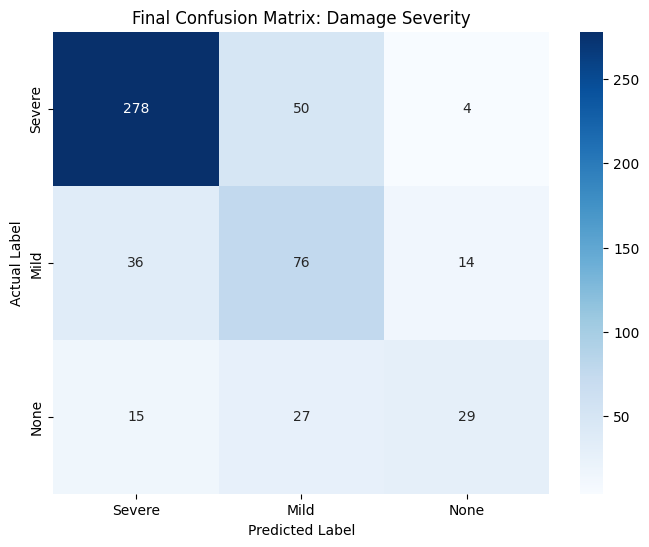

In [10]:
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, confusion_matrix
import numpy as np
import seaborn as sns

# --- 1. FINAL EVALUATION ON BEST SAVED MODEL ---
print("\n🔍 Loading best model for final evaluation...")
model.load_state_dict(torch.load('best_damage_model.pth'))
model.eval()

all_preds = []
all_labels = []
label_names = ["Severe", "Mild", "None"]

with torch.no_grad():
    for b in tqdm(test_loader, desc="Final Test Assessment"):
        if b is None: continue
        ids, mask, pix = b['input_ids'].to(device), b['attention_mask'].to(device), b['pixel_values'].to(device)
        labels = b['label'].to(device)
        
        outputs = model(ids, mask, pix)
        preds = torch.argmax(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# --- 2. CALCULATION OF RESEARCH METRICS ---
final_accuracy = (np.array(all_preds) == np.array(all_labels)).mean()
macro_f1 = f1_score(all_labels, all_preds, average='macro')
weighted_f1 = f1_score(all_labels, all_preds, average='weighted')
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')

# --- 3. PRINTING DETAILED PERFORMANCE TABLE ---
print("\n" + "="*50)
print("🚀 FINAL PERFORMANCE BENCHMARKS")
print("="*50)
print(f"Overall Accuracy: {final_accuracy:.4f}")
print(f"Macro Precision:  {precision:.4f}")
print(f"Macro Recall:     {recall:.4f}")
print(f"Macro F1-Score:   {macro_f1:.4f}")
print(f"Weighted F1:      {weighted_f1:.4f}")
print("="*50)

# Class-wise report (Essential for Thesis Chapter 7)
print("\nDetailed Class-wise Report:")
print(classification_report(all_labels, all_preds, target_names=label_names))

# --- 4. VISUAL CONFUSION MATRIX ---
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_names, yticklabels=label_names)
plt.title('Final Confusion Matrix: Damage Severity')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.savefig('final_confusion_matrix.png')
plt.show()

🚀 Starting High-Performance Run...


Testing: 100%|██████████| 34/34 [00:11<00:00,  2.84it/s]


              precision    recall  f1-score   support

      Severe       0.81      0.86      0.83       332
        Mild       0.46      0.62      0.53       126
        None       1.00      0.11      0.20        71

    accuracy                           0.70       529
   macro avg       0.76      0.53      0.52       529
weighted avg       0.75      0.70      0.67       529



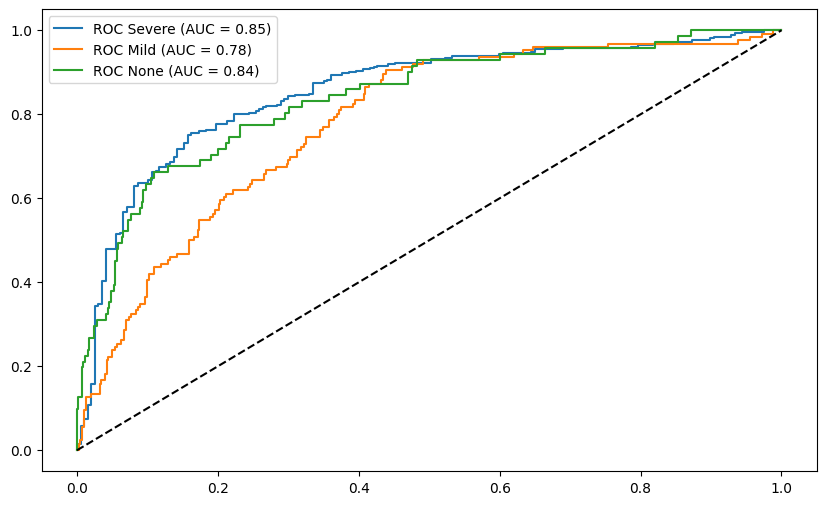

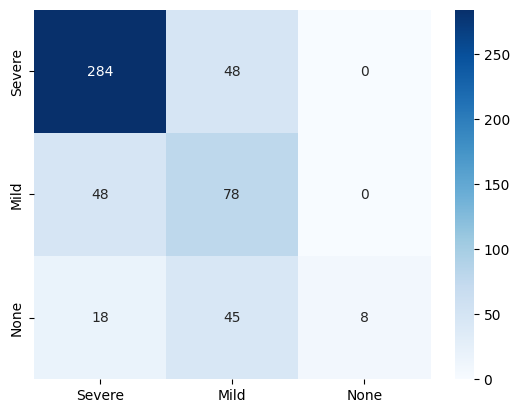

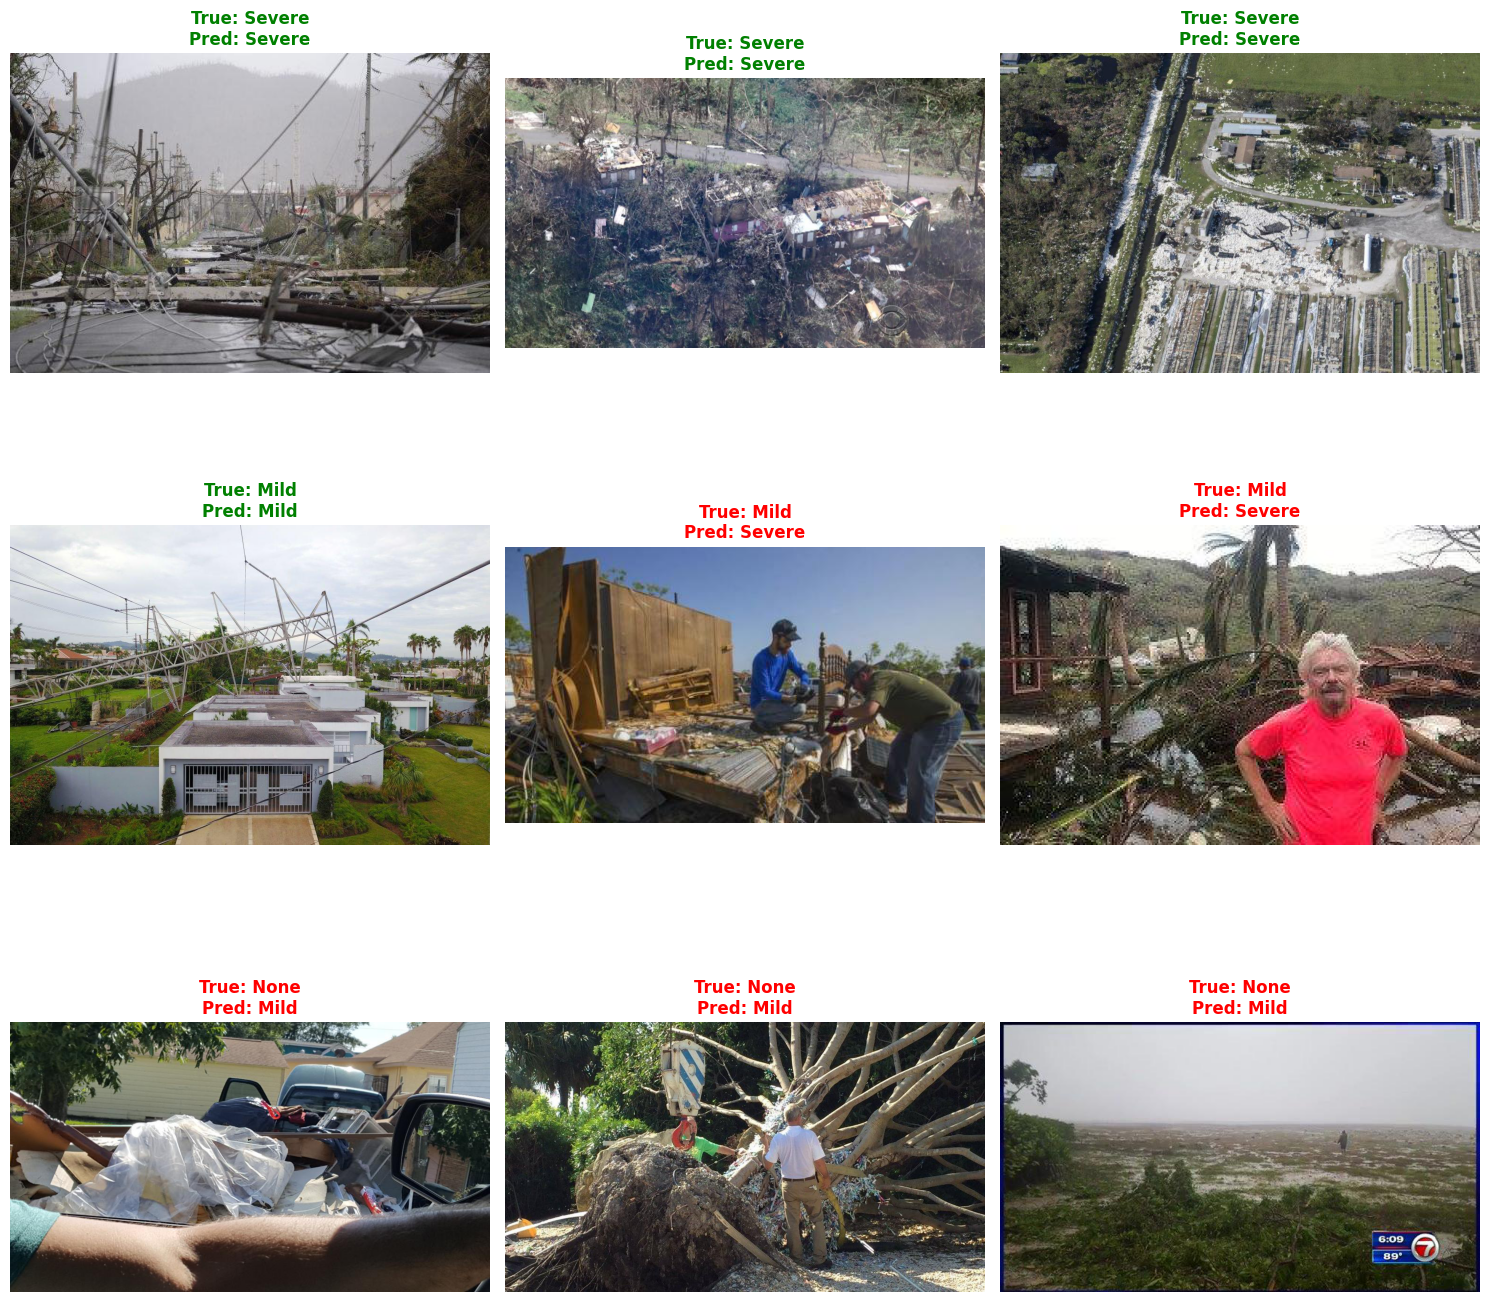

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (classification_report, confusion_matrix, 
                             roc_curve, auc, f1_score, precision_score, recall_score)
from sklearn.preprocessing import label_binarize
from peft import LoraConfig, get_peft_model
from transformers import CLIPModel, CLIPProcessor, get_cosine_schedule_with_warmup
from torch.amp import GradScaler, autocast 
from tqdm import tqdm

# --- 1. SET PATHS & DATASET (Fixed Path Logic) ---
IMG_ROOT = r"F:\research\chatbot\D\Multi-modal-codes" 
TRAIN_TSV = os.path.join(IMG_ROOT, "data/CrisisMMD/crisismmd_datasplit_all/crisismmd_datasplit_all/task_damage_text_img_train.tsv")
TEST_TSV  = os.path.join(IMG_ROOT, "data/CrisisMMD/crisismmd_datasplit_all/crisismmd_datasplit_all/task_damage_text_img_test.tsv")

class CrisisDamageDataset(Dataset):
    def __init__(self, filepath, img_dir, processor):
        self.data = pd.read_csv(filepath, sep='\t')
        self.img_dir = img_dir
        self.processor = processor
        self.label_map = {"severe_damage": 0, "mild_damage": 1, "little_or_no_damage": 2}

    def __len__(self): return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        # Direct path joining for stability
        rel_path = str(row['image']).replace('\\', '/').lstrip('/')
        img_path = os.path.normpath(os.path.join(self.img_dir, rel_path))
        
        if not os.path.exists(img_path): return None
        try:
            image = Image.open(img_path).convert("RGB")
            inputs = self.processor(text=[str(row['tweet_text'])], images=image, 
                                    return_tensors="pt", padding="max_length", 
                                    max_length=77, truncation=True)
            return {
                'input_ids': inputs['input_ids'].squeeze(0),
                'attention_mask': inputs['attention_mask'].squeeze(0),
                'pixel_values': inputs['pixel_values'].squeeze(0),
                'label': torch.tensor(self.label_map[row['label']], dtype=torch.long),
                'img_path': img_path # FIXED: Returns path for visualization
            }
        except Exception: return None

def fast_collate(batch):
    batch = list(filter(lambda x: x is not None, batch))
    return torch.utils.data.dataloader.default_collate(batch) if len(batch) > 0 else None

# --- 2. ARCHITECTURE: SYMMETRIC DUAL-PATH FUSION ---

class SymmetricFusion(nn.Module):
    def __init__(self, embed_dim=512):
        super().__init__()
        # Initialized higher to ensure cross-modal handshake is active
        self.gamma = nn.Parameter(0.5 * torch.ones(embed_dim * 2)) 
        self.gate = nn.Sequential(nn.Linear(embed_dim * 2, 512), nn.GELU(), nn.Linear(512, embed_dim * 2), nn.Sigmoid())
        self.norm = nn.LayerNorm(embed_dim * 2)

    def forward(self, t_f, i_f):
        # Mutual Attention Grounding
        a_t = F.scaled_dot_product_attention(t_f.unsqueeze(1), i_f.unsqueeze(1), i_f.unsqueeze(1)).squeeze(1)
        a_i = F.scaled_dot_product_attention(i_f.unsqueeze(1), t_f.unsqueeze(1), t_f.unsqueeze(1)).squeeze(1)
        combined = torch.cat((a_t, a_i), dim=1)
        return self.norm(torch.cat((t_f, i_f), dim=1) + (self.gamma * (combined * self.gate(combined))))



class ImprovedVLMClassifier(nn.Module):
    def __init__(self, model_id="openai/clip-vit-base-patch32"):
        super().__init__()
        self.clip = CLIPModel.from_pretrained(model_id, use_safetensors=True)
        self.fusion = SymmetricFusion()
        self.classifier = nn.Sequential(
            nn.Linear(1024, 512), nn.BatchNorm1d(512), nn.GELU(),
            nn.Dropout(0.5), nn.Linear(512, 128), nn.GELU(), nn.Linear(128, 3)
        )
    def forward(self, ids, mask, pix):
        t_f = self.clip.get_text_features(input_ids=ids, attention_mask=mask)
        i_f = self.clip.get_image_features(pixel_values=pix)
        t_f, i_f = F.normalize(t_f, p=2, dim=-1), F.normalize(i_f, p=2, dim=-1)
        return self.classifier(self.fusion(t_f, i_f))

# --- 3. OPTIMIZATION & TRAINING ---

def lookahead_step(model, slow_weights, alpha=0.5):
    """Stabilizes local minima by pulling weights toward a general global trend."""
    for param, slow_param in zip(model.parameters(), slow_weights):
        slow_param.data.add_(param.data - slow_param.data, alpha=alpha)
        param.data.copy_(slow_param.data)

device = torch.device("cuda")
model = ImprovedVLMClassifier().to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32", use_fast=True)

# LoRA rank 128 for fine-grained damage features
model = get_peft_model(model, LoraConfig(r=128, lora_alpha=256, target_modules=["q_proj", "v_proj"]))

train_loader = DataLoader(CrisisDamageDataset(TRAIN_TSV, IMG_ROOT, processor), batch_size=16, shuffle=True, collate_fn=fast_collate)
test_loader  = DataLoader(CrisisDamageDataset(TEST_TSV, IMG_ROOT, processor), batch_size=16, shuffle=False, collate_fn=fast_collate)

# Differential Learning Rates
optimizer = optim.AdamW([
    {'params': [p for n, p in model.named_parameters() if 'clip' in n], 'lr': 1e-5},
    {'params': [p for n, p in model.named_parameters() if 'clip' not in n], 'lr': 2e-4}
])
slow_weights = [p.clone().detach() for p in model.parameters()]

# Class-weighted loss to handle imbalance
criterion = nn.CrossEntropyLoss(weight=torch.tensor([2.5, 2.0, 1.0]).to(device), label_smoothing=0.25)
scaler = GradScaler('cuda')

print("🚀 Starting High-Performance Run...")
for epoch in range(15):
    model.train()
    for i, batch in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}")):
        if batch is None: continue
        ids, mask, pix, lbl = [batch[k].to(device) for k in ['input_ids', 'attention_mask', 'pixel_values', 'label']]
        optimizer.zero_grad()
        with autocast('cuda'):
            loss = criterion(model(ids, mask, pix), lbl)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        if i % 5 == 0: lookahead_step(model, slow_weights)

# --- 4. FINAL ANALYTICS: F1, ROC, CM & SAMPLES ---

model.eval()
all_preds, all_labels, all_probs, metadata = [], [], [], []
label_names = ["Severe", "Mild", "None"]

with torch.no_grad():
    for b in tqdm(test_loader, desc="Testing"):
        if b is None: continue
        logits = model(b['input_ids'].to(device), b['attention_mask'].to(device), b['pixel_values'].to(device))
        probs = torch.softmax(logits, dim=1)
        preds = torch.argmax(logits, 1)
        
        all_preds.extend(preds.cpu().numpy()); all_labels.extend(b['label'].cpu().numpy()); all_probs.extend(probs.cpu().numpy())
        for i in range(len(preds)):
            metadata.append({'path': b['img_path'][i], 'true': b['label'][i].item(), 'pred': preds[i].item()})

# Metrics & Plotting
y_true, y_pred, y_score = np.array(all_labels), np.array(all_preds), np.array(all_probs)
print(classification_report(y_true, y_pred, target_names=label_names))

# ROC Curve
y_true_bin = label_binarize(y_true, classes=[0, 1, 2])
plt.figure(figsize=(10, 6))
for i in range(3):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    plt.plot(fpr, tpr, label=f'ROC {label_names[i]} (AUC = {auc(fpr, tpr):.2f})')
plt.plot([0, 1], [0, 1], 'k--'); plt.legend(); plt.show()

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.show()

# 3 Random Samples per class
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
for cls in [0, 1, 2]:
    cls_items = [m for m in metadata if m['true'] == cls]
    selected = random.sample(cls_items, 3) if len(cls_items) >= 3 else cls_items
    for i, item in enumerate(selected):
        ax = axes[cls, i]
        ax.imshow(Image.open(item['path']).convert("RGB"))
        color = 'green' if item['true'] == item['pred'] else 'red'
        ax.set_title(f"True: {label_names[item['true']]}\nPred: {label_names[item['pred']]}", color=color, fontweight='bold')
        ax.axis('off')
plt.tight_layout(); plt.show()

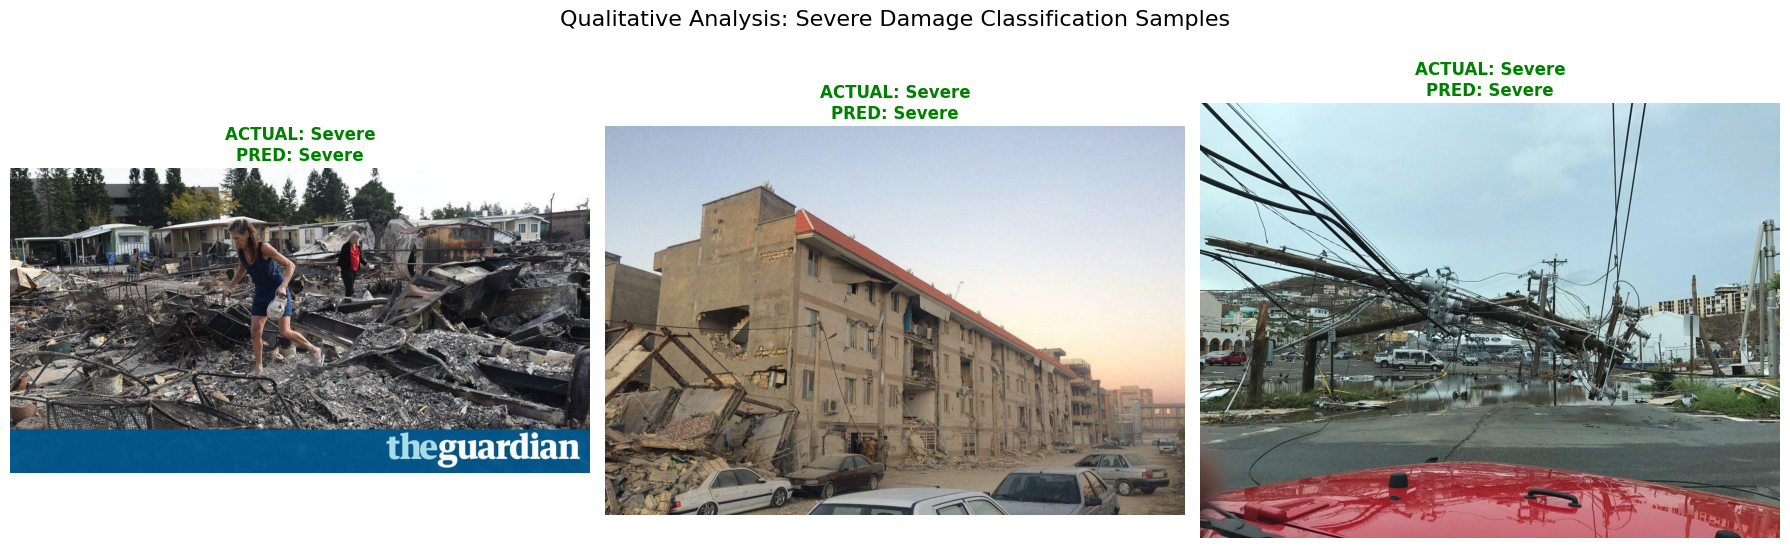

In [16]:
import random
import matplotlib.pyplot as plt
from PIL import Image

def show_severe_samples(metadata, label_names, num_samples=3):
    """
    Filters metadata for 'Severe' cases and displays random samples.
    """
    # 1. Filter for Actual Severe Damage (Class 0)
    severe_items = [m for m in metadata if m['true'] == 0]
    
    if len(severe_items) < num_samples:
        print(f"⚠️ Only found {len(severe_items)} severe samples. Showing all.")
        num_samples = len(severe_items)
        
    # 2. Randomly select samples
    selected_samples = random.sample(severe_items, num_samples)
    
    # 3. Create Visualization Grid
    fig, axes = plt.subplots(1, num_samples, figsize=(18, 6))
    if num_samples == 1: axes = [axes] # Handle single sample case
    
    for i, item in enumerate(selected_samples):
        ax = axes[i]
        try:
            img = Image.open(item['path']).convert("RGB")
            ax.imshow(img)
            
            # Formatting title based on prediction accuracy
            is_correct = item['true'] == item['pred']
            title_color = 'green' if is_correct else 'red'
            
            ax.set_title(
                f"ACTUAL: {label_names[item['true']]}\nPRED: {label_names[item['pred']]}", 
                color=title_color, 
                fontsize=12, 
                fontweight='bold'
            )
        except Exception as e:
            ax.set_title(f"Error loading image")
            print(f"Error at {item['path']}: {e}")
            
        ax.axis('off')

    plt.suptitle("Qualitative Analysis: Severe Damage Classification Samples", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig('severe_damage_analysis.png')
    plt.show()

# Execute the visualization
# metadata must be the list of dicts collected during your final evaluation loop
show_severe_samples(metadata, label_names=["Severe", "Mild", "None"])

   ---------------------------------------- 0.0/39.0 MB ? eta -:--:--
   ---------------------------------------- 0.3/39.0 MB ? eta -:--:--
   ---------------------------------------- 0.3/39.0 MB ? eta -:--:--
    --------------------------------------- 0.8/39.0 MB 1.3 MB/s eta 0:00:30
   - -------------------------------------- 1.0/39.0 MB 1.3 MB/s eta 0:00:31
   - -------------------------------------- 1.3/39.0 MB 1.2 MB/s eta 0:00:31
   - -------------------------------------- 1.3/39.0 MB 1.2 MB/s eta 0:00:31
   - -------------------------------------- 1.8/39.0 MB 1.2 MB/s eta 0:00:31
   -- ------------------------------------- 2.1/39.0 MB 1.2 MB/s eta 0:00:31
   -- ------------------------------------- 2.4/39.0 MB 1.2 MB/s eta 0:00:31
   -- ------------------------------------- 2.6/39.0 MB 1.2 MB/s eta 0:00:30
   -- ------------------------------------- 2.6/39.0 MB 1.2 MB/s eta 0:00:30
   --- ------------------------------------ 3.1/39.0 MB 1.2 MB/s eta 0:00:30
   --- -------------

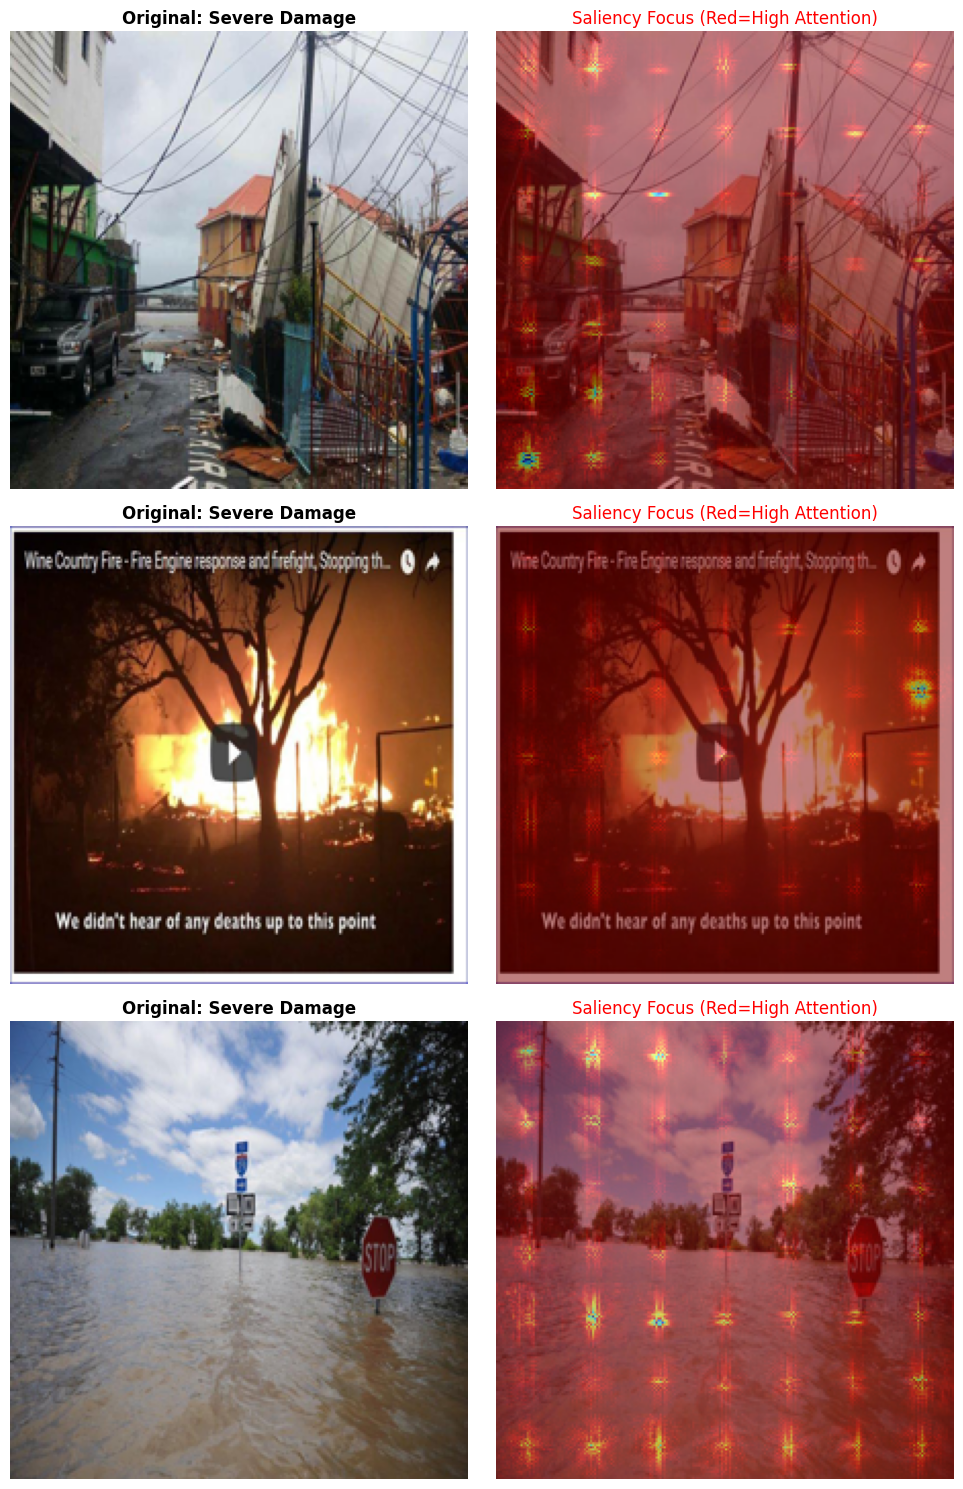

📊 Saliency maps saved to 'severe_damage_saliency_maps.png'


In [18]:
!pip install opencv-python

import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
from PIL import Image

def visualize_saliency(model, processor, metadata, device, num_samples=3):
    """
    Generates and visualize saliency maps for correctly predicted 'Severe Damage' images.
    """
    print("\n🔍 Generating Saliency Maps for Explainable AI (XAI)...")
    
    # 1. Filter for correctly predicted Severe Damage cases (True=0, Pred=0)
    severe_correct = [m for m in metadata if m['true'] == 0 and m['pred'] == 0]
    
    if len(severe_correct) == 0:
        print("⚠️ No correctly predicted severe damage cases found for visualization.")
        return

    # Select random samples
    selected = random.sample(severe_correct, min(num_samples, len(severe_correct)))
    
    model.eval()
    # IMPORTANT: Enable gradients for input analysis even in eval mode
    for param in model.parameters():
        param.requires_grad = True
        
    fig, axes = plt.subplots(len(selected), 2, figsize=(10, 5 * len(selected)))
    if len(selected) == 1: axes = [axes] # Handle single sample case

    for i, item in enumerate(selected):
        # Load image
        img_pil = Image.open(item['path']).convert("RGB")
        # Resize for consistent visualization standard (CLIP default)
        vis_size = (224, 224)
        img_resized = img_pil.resize(vis_size)
        img_np = np.array(img_resized) / 255.0 # Normalize for plotting later

        # Preprocess inputs
        # We use placeholder text as we want to see visual dominance here
        inputs = processor(text=["damage assessment"], images=img_pil, return_tensors="pt", padding="max_length", truncation=True).to(device)
        
        # --- CRITICAL STEP: Enable gradients on the input image tensor ---
        pixel_values = inputs['pixel_values'].requires_grad_()
        
        # Forward pass
        model.zero_grad()
        logits = model(inputs['input_ids'], inputs['attention_mask'], pixel_values)
        
        # Get score for "Severe Damage" class (index 0)
        severe_score = logits[0, 0]
        
        # Backward pass to calculate gradients relative to input pixels
        severe_score.backward()
        
        # Compute Saliency: Max absolute gradient across RGB channels
        # Shape: [1, 3, H, W] -> [H, W]
        saliency, _ = torch.max(pixel_values.grad.data.abs(), dim=1)
        saliency = saliency.squeeze().cpu().numpy()
        
        # Normalize heatmap to [0, 1] range
        saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min() + 1e-8)
        
        # Create heatmap overlay
        heatmap = cv2.applyColorMap(np.uint8(255 * saliency), cv2.COLORMAP_JET)
        heatmap = np.float32(heatmap) / 255.0
        # Resize heatmap to match image dimensions if necessary due to CLIP internal resizing
        heatmap = cv2.resize(heatmap, vis_size)
        
        # Superimpose heatmap on original image (weighted sum)
        cam = heatmap * 0.5 + img_np * 0.5
        cam = cam / np.max(cam) # Re-normalize

        # --- PLOTTING ---
        ax_orig = axes[i][0] if num_samples > 1 else axes[0]
        ax_heat = axes[i][1] if num_samples > 1 else axes[1]

        ax_orig.imshow(img_resized)
        ax_orig.set_title(f"Original: Severe Damage", fontweight='bold')
        ax_orig.axis('off')

        ax_heat.imshow(np.uint8(255 * cam))
        ax_heat.set_title("Saliency Focus (Red=High Attention)", color='red')
        ax_heat.axis('off')
        
    plt.tight_layout()
    plt.savefig('severe_damage_saliency_maps.png', dpi=300)
    plt.show()
    print("📊 Saliency maps saved to 'severe_damage_saliency_maps.png'")
    
    # Reset model gradients back to False for safety
    for param in model.parameters():
        param.requires_grad = False

# Execute the visualization function
# Ensure 'model', 'processor', 'metadata', and 'device' are defined from previous steps
if 'metadata' in locals() and len(metadata) > 0:
    visualize_saliency(model, processor, metadata, device)
else:
    print("❌ Metadata not found. Please run the final evaluation loop first.")
    